# Introdução às Redes Neurais Convolucionais (Dia 03) Picture1.jpg

---
## Introdução

**Objetivo:** resolver o problema de classificação de um objeto do dataset CIFAR-10 construindo uma rede neural convolucional o Keras.

* Este dataset contém 60 mil imagens coloridas distribuídas em 10 classes distintas: avião, carro, pássaro, gato, veado, cachorro, sapo, cavalo, barco, caminhão.

* As 60 mil imagens são distribuídas em 50 mil para treino e 10 mil para teste.

---
Assim como nos demais exemplos, começamos importando as bibliotecas necessárias para o trabalho. Aqui estamos importando o `Keras`, `pyplot`, `scikit-learn` e `seaborn`.

Perceba que estamos chamando métodos novos como: `Dropout` e `BatchNormalization`.

In [ ]:
import keras
from keras.datasets import cifar10
from keras.models import Sequential
from keras import datasets, layers, models
from keras.utils import to_categorical
from keras import regularizers
from keras.layers import Dense, Dropout, BatchNormalization
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

---
O CIFAR-10 também é parte do `Keras`, logo para carregar as imagens de treino e teste basta usar o método `load_data()`.

In [ ]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step


---
Vamos analisar a estrutura dos dados que carregamos

In [ ]:
# Checando os tensores
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


Note que as imagens agora são ligeiramente maiores do que aquelas do MNIST, elas tem dimensão $32\times 32$. Um outro detalhe, as imagens são coloridas. Nesta situação cada imagem é formada por 3 matrizes, uma contendo a intensidade luminosa do vermelho, outra do verde e outra do azul (RGB).

---

Agora precisamos verificar quais são os rótulos de cada tipo de imagem. Neste caso são numéricos também. Isso nos sugere que devemos transformá-los também para o formato categórico.

In [ ]:
# Verificando as etiquetas únicas
print(np.unique(train_labels))
print(np.unique(test_labels))

[0 1 2 3 4 5 6 7 8 9]
[0 1 2 3 4 5 6 7 8 9]


---
Agora vamos criar os rótulos (palavras) que serão associados às classes numéricas.

In [ ]:
# Criando a lista das etiquetas
class_names = ['avião', 'carro', 'pássaro', 'gato', 'veado',
               'cachorro', 'sapo', 'cavalo', 'barco', 'caminhão']

---
Não custa nada dar uma olhadinha nas imagens e nos rótulos que temos.

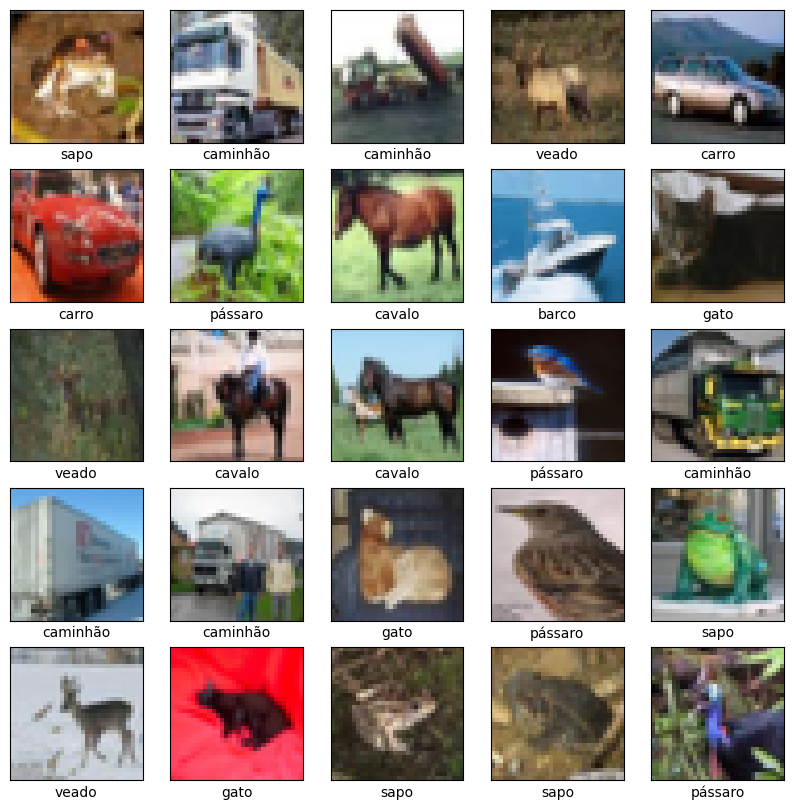

In [ ]:
# Mostrando alguns dados do dataset
plt.figure(figsize=[10,10])
for i in range (25):
  plt.subplot(5, 5, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(train_images[i], cmap=plt.cm.binary)
  plt.xlabel(class_names[train_labels[i][0]])

plt.show()

---
É importante verificarmos se será necessário fazer uma normalização.

array([[[ 59,  62,  63],
        [ 43,  46,  45],
        [ 50,  48,  43],
        ...,
        [158, 132, 108],
        [152, 125, 102],
        [148, 124, 103]],

       [[ 16,  20,  20],
        [  0,   0,   0],
        [ 18,   8,   0],
        ...,
        [123,  88,  55],
        [119,  83,  50],
        [122,  87,  57]],

       [[ 25,  24,  21],
        [ 16,   7,   0],
        [ 49,  27,   8],
        ...,
        [118,  84,  50],
        [120,  84,  50],
        [109,  73,  42]],

       ...,

       [[208, 170,  96],
        [201, 153,  34],
        [198, 161,  26],
        ...,
        [160, 133,  70],
        [ 56,  31,   7],
        [ 53,  34,  20]],

       [[180, 139,  96],
        [173, 123,  42],
        [186, 144,  30],
        ...,
        [184, 148,  94],
        [ 97,  62,  34],
        [ 83,  53,  34]],

       [[177, 144, 116],
        [168, 129,  94],
        [179, 142,  87],
        ...,
        [216, 184, 140],
        [151, 118,  84],
        [123,  92,  72]]], dtype=uint8)
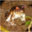

In [ ]:
train_images[0]

---
Vimos que as imagens aqui também possuem entradas inteiras entre 0 e 255. Portanto, vamos fazer a mesma normalização que fizemos com os dados do MNIST. Vamos dividir as imagens de treino e teste por 255.

Além disso, vamos identificar cada rótulo numérico à um vetor canônico do $\mathbb{R}^{10}$, em que cada vetor representa uma classe diferente.

In [ ]:
# Normalizando as imagens
train_images = train_images / 255
test_images = test_images / 255

# Codificação one-hot das etiquetas
num_classes = 10
train_labels = to_categorical(train_labels, num_classes)
test_labels = to_categorical(test_labels, num_classes)

---
Finalmente, vamos criar o modelo.

* Usamos também o método `Sequential()` para criarmos uma rede convolucional.
* As camadas convolucionais são chamadas com o método `Conv2D()`. Este método requer vários parâmetros, como quantidade de filtros, tamanho do filtro, tipo de preenchimento (padding), tipo de função de ativação, dentre outros. Identificando aqui a camada de entrada temos: `layersConv2D(32, (3,3), padding='same', activation='relu', input_shape=(32,32,3))`, isto é, são 32 filtros que agirão na camada de entrada de dimensão $3\times 3$, o preenchimento deve manter o tamanho original da imagem e a função de ativação associada é a `ReLU`.
* Logo após a primeira camada convolucional procedemos com uma normalização de lote e iremos proceder com essa normalização sempre após uma camada.
* Depois de duas camadas convolucionais fazemos uma camada não-treinável de *pooling* com o método `MaxPooling2D()`, o `pool_size=(dim1,dim2)` corresponde ao tamanho da redução. No nosso caso estamos reduzindo cada uma das dimensões da imagem original por 2.
* Finalmente, vem a primeira camada de dropout que está desligando 20% dos neurônios. Para o método `Dropout()` o parâmetro `rate` varia entre 0 e 1.
* Observe que estamos repetindo a estrutura desse bloco mais duas vezes dobrando a quantidade de filtros em cada um deles.
* No quarto e último bloco vem inicialmente uma camada densa com 128 neurônios e em seguida uma camada de 10 neurônios para a saída, com ativação `softmax`.

In [ ]:
# Criando um modelo sequência e adicionando camadas nele

model = Sequential()

model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(32,32,3)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu')) # retorna um tensor 4D dado por ativação(conv2d(inputs, kernel) + viés).
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Dropout(0.2))

model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(num_classes, activation='softmax'))    # num_classes = 10

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


---
Vamos agora mostrar o resumo do modelo.

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 8, 8, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 552,874 (2.11 MB)

 Trainable params: 551,722 (2.10 MB)

 Non-trainable params: 1,152 (4.50 KB)

---
Compilando o modelo.

Vamos de: ADAM, cross-entropy e a métrica é a acurácia.

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

---
Para treinar o modelo vamos fazer um treinamento com 12 épocas e em lotes de 64 imagens.

*Obs:* na descida de gradiente em lote você processa todo o conjunto de treinamento em uma iteração. Enquanto que em uma descida de gradiente em minilotes você processa um pequeno subconjunto do conjunto de treinamento em cada iteração. Neste caso, em lotes de tamanho 64.

In [ ]:
history = model.fit(train_images, train_labels, batch_size=64, epochs=12,
                    validation_data=(test_images, test_labels))

Epoch 1/12
782/782 ━━━━━━━━━━━━━━━━━━━━ 27s 19ms/step - accuracy: 0.4287 - loss: 1.6575 - val_accuracy: 0.5839 - val_loss: 1.1861
Epoch 2/12
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.6806 - loss: 0.9091 - val_accuracy: 0.7071 - val_loss: 0.8551
Epoch 3/12
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.7439 - loss: 0.7287 - val_accuracy: 0.7192 - val_loss: 0.8221
Epoch 4/12
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.7789 - loss: 0.6312 - val_accuracy: 0.7495 - val_loss: 0.7314
Epoch 5/12
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.8052 - loss: 0.5639 - val_accuracy: 0.7941 - val_loss: 0.6128
Epoch 6/12
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.8255 - loss: 0.4924 - val_accuracy: 0.7680 - val_loss: 0.6954
Epoch 7/12
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.8453 - loss: 0.4408 - val_accuracy: 0.8059 - val_loss: 0.5708
Epoch 8/12
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.8569 - loss: 0.4102 - val_accur

Visualizando e avaliando os resultados

Text(0.5, 1.0, 'Loss Curves')

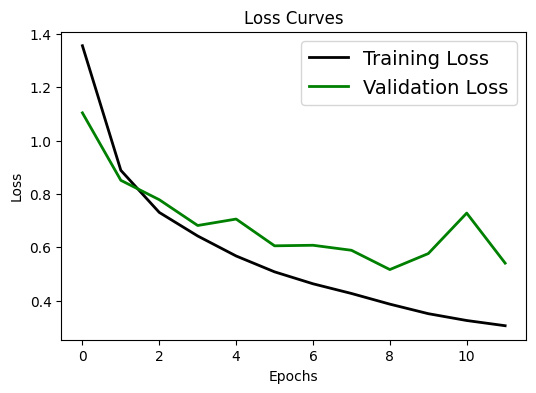

In [ ]:
# Curva de perda
plt.figure(figsize=[6,4])
plt.plot(history.history['loss'], 'black', linewidth=2.0)
plt.plot(history.history['val_loss'], 'green', linewidth=2.0)
plt.legend(['Perda do treino', 'Perda da validação'], fontsize=14)
plt.xlabel('Épocas', fontsize=10)
plt.ylabel('Perda', fontsize=10)
plt.title('Curvas de perda', fontsize=12)

Text(0.5, 1.0, 'Accuracy Curves')

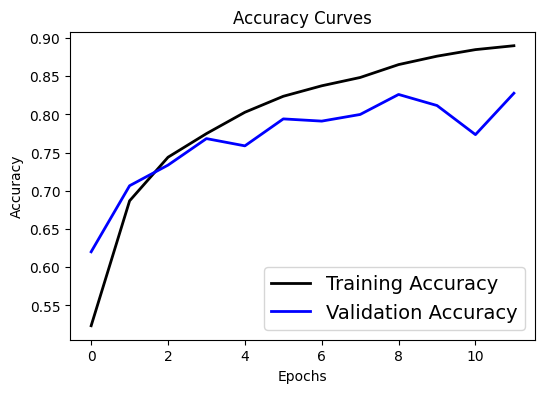

In [ ]:
# Curva de acurácia
plt.figure(figsize=[6,4])
plt.plot(history.history['accuracy'], 'black', linewidth=2.0)
plt.plot(history.history['val_accuracy'], 'blue', linewidth=2.0)
plt.legend(['Acurácia do treino', 'Acurácia da validação'], fontsize=14)
plt.xlabel('Épocas', fontsize=10)
plt.ylabel('Acurácia', fontsize=10)
plt.title('Curva de acurácia', fontsize=12)

---
Agora é a hora de ver se o modelo treinou direitinho

In [ ]:
# Fazendo as previsões
pred = model.predict(test_images)
print(pred)

# Convertendo as previsões nos índices das etiquetas
pred_classes = np.argmax(pred, axis=1)
print(pred_classes)

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
[[2.3809719e-06 2.5355688e-04 7.0162198e-05 ... 1.5751145e-07
  6.2048703e-06 2.9116413e-06]
 [7.6615061e-06 1.0553262e-02 1.5624384e-08 ... 6.6869338e-10
  9.8943865e-01 3.0933398e-07]
 [1.9182612e-03 7.1760863e-01 1.4021850e-04 ... 3.4321736e-05
  2.8002945e-01 1.2413114e-04]
 ...
 [2.2500219e-06 2.9376241e-07 7.6022890e-04 ... 2.5103707e-04
  1.4749182e-06 4.7252275e-08]
 [1.0578970e-02 9.8911208e-01 1.5412214e-05 ... 3.3502033e-06
  5.3756423e-05 1.4406790e-04]
 [1.9543158e-07 2.5171761e-07 2.5074021e-06 ... 9.9995780e-01
  1.9064732e-09 2.1001909e-09]]
[3 8 1 ... 5 1 7]


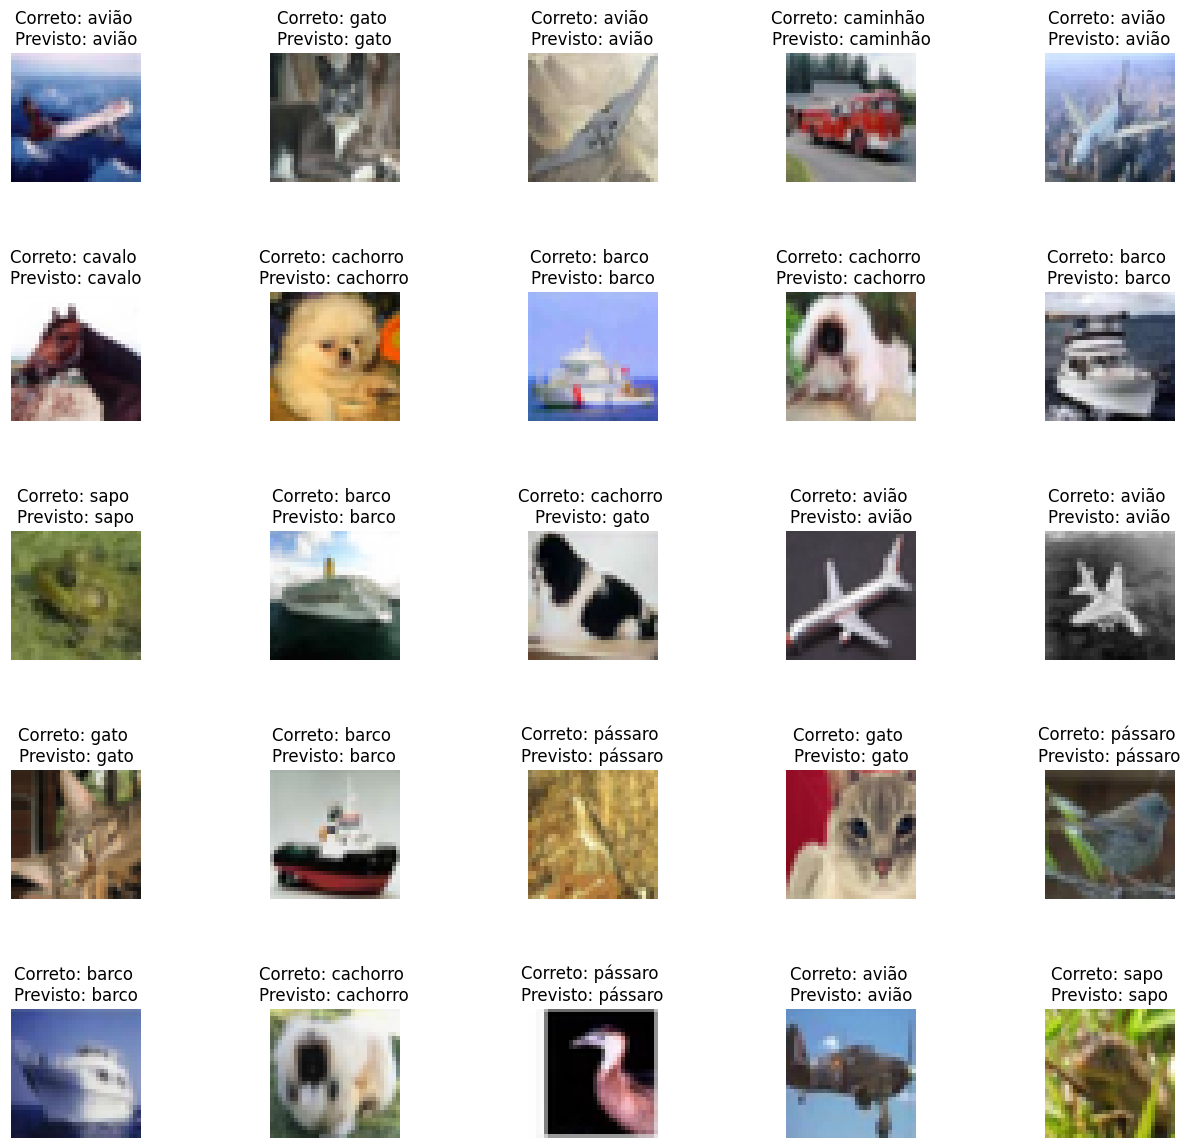

In [ ]:
# Mostrando o verdadeiro vs. Resultado previsto

fig, axes = plt.subplots(5, 5, figsize=(15,15))
axes = axes.ravel()

for i in np.arange(0, 25):
    random_num = np.random.choice(len(test_images))
    axes[i].imshow(test_images[random_num])
    axes[i].set_title("Correto: %s \nPrevisto: %s" % (class_names[np.argmax(test_labels[random_num])], class_names[pred_classes[random_num]]))
    axes[i].axis('off')
    plt.subplots_adjust(wspace=1)

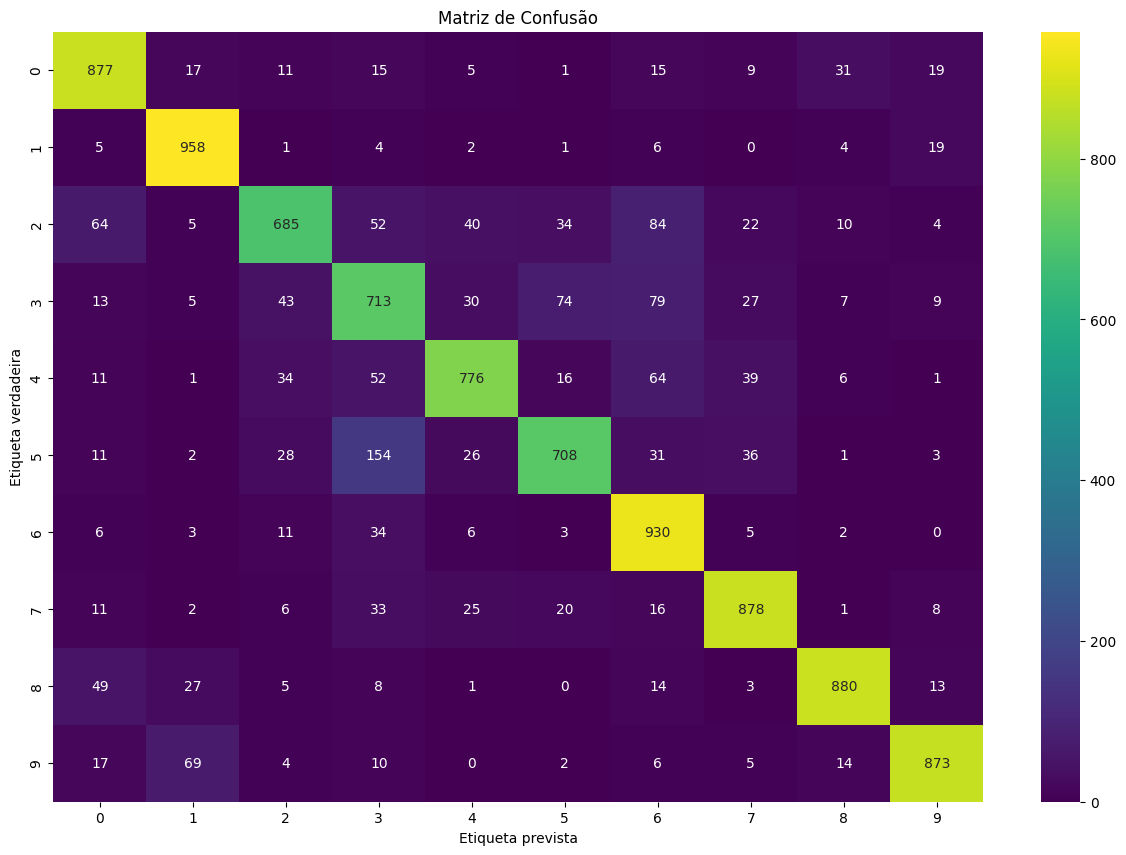

In [ ]:
# Gera a matriz de confusão
confusion_mtx = confusion_matrix(np.argmax(test_labels, axis=1), pred_classes)

# Plota a matriz de confusão
fig, ax = plt.subplots(figsize=(15, 10))
ax = sns.heatmap(confusion_mtx, annot=True, fmt="d", ax=ax, cmap="viridis")
ax.set_xlabel("Etiqueta prevista")
ax.set_ylabel("Etiqueta verdadeira")
ax.set_title("Matriz de Confusão");